In [ ]:
# Cells where inputs should be specified are labelled as #INPUT

In [1]:
import scipy, time, sys
from scipy.fftpack import fft2, fftn, ifftn
from scipy.special import hyp2f1
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import quad, tplquad
from scipy.misc import derivative
import numpy as np
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt, amin, amax, mean
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.insert(0, '/Users/digvijay/Dropbox/Drop_Acad/Roman/Covariance/Public_CovaPT/detail')
import T0

In [ ]:
# import importlib
# importlib.reload(T0)
#import multiprocessing
#from subprocess import call
#from astropy.io import fits
#from sympy import *

In [2]:
# Aesthetic definitions for the plots
font = {'size'   : 14, 'family':'STIXGeneral'}
matplotlib.rc('font', **font)
matplotlib.rc('axes', labelsize=18) 
matplotlib.mathtext.rcParams['legend.fontsize']=16
plt.rcParams["figure.figsize"] = [6.0,4.]

#matplotlib.rc('font',**{'family':'serif','serif':['Palatino']})
matplotlib.rc('text', usetex=True)

In [3]:
# If you want to use my input files in this code, please download them from below and set the directory location:
# https://drive.google.com/drive/folders/1bWKfUaIXcC1n-2hk9KtKhqukxTH1379i?usp=sharing

dire='/Users/digvijay/Dropbox/Drop_Acad/Roman/Covariance/data/Public/'

In [4]:
#INPUT

# array of k-values
dk=0.01 #Bin width
k=np.arange(0.005,0.25,dk); #k contains the bin centers
kbins=len(k) #number of k-bins

In [5]:
# Growth factor and growth rate for LCDM case
def Dz(z,Om0):
    return(scipy.special.hyp2f1(1/3., 1, 11/6., (1-1/Om0)/(1+z)**3)
                                /scipy.special.hyp2f1(1/3., 1, 11/6., 1-1/Om0)/(1+z))

def fgrowth(z,Om0):
    return(1. + 6*(Om0-1)*scipy.special.hyp2f1(4/3., 2, 17/6., (1-1/Om0)/(1+z)**3)
                  /( 11*Om0*(1+z)**3*scipy.special.hyp2f1(1/3., 1, 11/6., (1-1/Om0)/(1+z)**3) ))

In [6]:
#INPUT

# Enter Omega_m and z values
Om = 0.307115
z = 0.58

# Enter bias parameter values

b1 = 1.94853182918671; #Linear bias
be = fgrowth(z, Om)/b1; #beta = f/b1, zero for real space

# Below are expressions for non-local bias (g_i) from local lagrangian approximation
# and non-linear bias (b_i) from peak-background split fit of 
# Lazyeras et al. 2016 (rescaled using Appendix C.2 of arXiv:1812.03208),
# which could used if those parameters aren't constrained.

g2 = -2/7*(b1 - 1)
g3 = 11/63*(b1 - 1);
b2 = 0.412 - 2.143*b1 + 0.929*b1**2 + 0.008*b1**3 + 4/3*g2 
g2x = -2/7*b2;
g21 = -22/147*(b1 - 1);
b3 = -1.028 + 7.646*b1 - 6.227*b1**2 + 0.912*b1**3 + 4*g2x - 4/3*g3 - 8/3*g21 - 32/21*g2

#Initializing the trispectrum code with the bias params
T0.InitParameters([b1,be,g2,b2,g3,g2x,g21,b3])

In [7]:
#INPUT

# Linear power spectrum from Class or CAMB
# Note that Plin used in code has factors of b1 and Dz
pdata=np.loadtxt(dire+'Pk_lin_CAMB.dat')
Plin=InterpolatedUnivariateSpline(pdata[:,0], Dz(z, Om)**2*b1**2*pdata[:,1])

Text(0, 0.5, '$b_1^2\\ D(z)^2\\ P_\\mathrm{lin}(k)$')

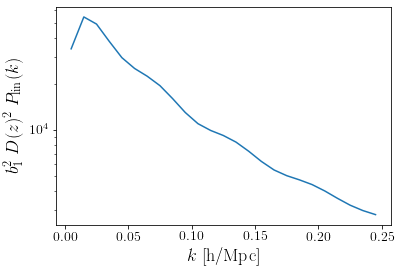

In [8]:
plt.semilogy(k,Plin(k))
plt.xlabel(r"$k$  [h/Mpc]"); plt.ylabel(r"$b_1^2\ D(z)^2\ P_\mathrm{lin}(k)$")

In [9]:
#INPUT

Lbox = 1000 #Mpc/h
vol = Lbox**3 #Volume of box/survey

inbar = Lbox**3/158262. #Inverse of galaxy number density

Nmodes = vol/3/(2*pi**2)*( (k+dk/2)**3-(k-dk/2)**3) #Number of k-modes in shells

# Real Space

In [49]:
#Best-fit theory power fitted to survey data (currently used same as Plin)

#Pfit=InterpolatedUnivariateSpline(pdata[:,0], pdata[:,1])
Pfit= lambda k: Plin(k)

In [50]:
CovGaussian=2*(Pfit(k) + inbar)**2/Nmodes

Text(0, 0.5, '$C_\\mathrm{Gauss}(k,k)/P(k)^2$')

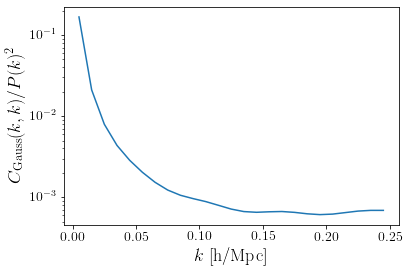

In [12]:
#Plotting diagonal elements of the Gaussian covariance matrix
plt.semilogy(k,CovGaussian/(Plin(k)**2))
plt.xlabel(r"$k$  [h/Mpc]"); plt.ylabel(r"$C_\mathrm{Gauss}(k,k)/P(k)^2$")

In [13]:
# Now calculating terms for the regular trispectrum (tree-level) part

# Let us first focus on the trispectrum terms, the expressions below are taken from a mathematica notebook
# which shows their derivation and will be uploaded soon

# First Z1 Z1 Z2 shot noise term in Eq. 91
def e34o44_1(k1,k2):
    expr = ((34/(21.*b1) + b2/b1**2 - (4*g2)/(3.*b1**2))/2.)
    return(expr)

# Second Z1 Z1 Z2 shot noise term in Eq. 91
def e34o44_2(u12,k1,k2):
    return((7*b2 + (k2**2*(-7*b1*k2*u12 + b1*k1*(3 - 10*u12**2) + 14*g2*k1*(-1 + u12**2)))
           /(k1*(k1**2 + k2**2 + 2*k1*k2*u12)))/(14.*b1**2))

# First Z1^2 Z2^2 term in Eq. 25
def e44o44_1(u12,k1,k2):
    return((7*b2*k1*(k1**2 + k2**2 + 2*k1*k2*u12) + k2**2*(-7*b1*k2*u12 + b1*k1*(3 - 10*u12**2) 
           + 14*g2*k1*(-1 + u12**2)))**2/(196.*b1**4*k1**2*(k1**2 + k2**2 + 2*k1*k2*u12)**2))

# Second Z1^2 Z2^2 term in Eq. 25
def e44o44_2(u12,k1,k2):
    return(((-3*b1*k1**2*k2 - 7*b2*k1**2*k2 + 14*g2*k1**2*k2 - 7*b2*k2**3 + 7*b1*k1**3*u12 - 14*b2*k1*k2**2*u12
          + 10*b1*k1**2*k2*u12**2 - 14*g2*k1**2*k2*u12**2)*(-7*b2*k1**3 - 3*b1*k1*k2**2 - 7*b2*k1*k2**2 
          + 14*g2*k1*k2**2 - 14*b2*k1**2*k2*u12 + 7*b1*k2**3*u12 + 10*b1*k1*k2**2*u12**2 - 14*g2*k1*k2**2*u12**2))
          /(196.*b1**4*k1*k2*(k1**2 + k2**2 + 2*k1*k2*u12)**2))

# Z3 term in Eq. 25
def ez3(k1,k2): 
    if(k1!=k2):
        return((4*k1*k2*(-21*(b1 + 3*g21)*k1**6 + (50*b1 + 3*(816*b2 + 84*b3 + 77*g21 - 224*g2x))*k1**4*k2**2 
               + (-79*b1 + 231*g21)*k1**2*k2**4 + 3*(2*b1 - 21*g21)*k2**6) - 3*(k1 - k2)**3*(k1 + k2)**3
               *(7*(b1 + 3*g21)*k1**2 + (2*b1 - 21*g21)*k2**2)*(np.log((k1 - k2)**2) - 2*np.log(k1 + k2)))
               /(504.*b1**3*k1**5*k2**3))
    else:
        return((-22*b1 + 1224*b2 + 42*(3*b3 + 4*g21 - 8*g2x))/(63.*b1**3))
    
def trispIntegrand(u12,k1,k2):
    return((8*(Plin(k1)**2*e44o44_1(u12,k1,k2) + Plin(k2)**2*e44o44_1(u12,k2,k1))
            +16*Plin(k1)*Plin(k2)*e44o44_2(u12,k1,k2)
            +8*inbar*(Plin(k1)*e34o44_2(u12,k1,k2)+Plin(k2)*e34o44_2(u12,k2,k1))+2*inbar**2)
            *Plin(np.sqrt(k1**2+k2**2+2*k1*k2*u12)))

# Combining all the trispectrum terms of the covariance
def trisp(k1,k2):
    expr = Plin(k1)**2*Plin(k2)*ez3(k1,k2) + Plin(k2)**2*Plin(k1)*ez3(k2,k1)\
        +8*inbar*Plin(k1)*Plin(k2)*e34o44_1(k1,k2)
    
    temp = (quad(trispIntegrand, -1, 1,args=(k1,k2))[0]/2. + expr)/vol
    return(temp)

trisp = np.vectorize(trisp)

In [14]:
# For making plots of a row of the covariance
it=20;
plotTrisp=trisp(k[it],k)/(Pfit(k[it])*Pfit(k))
total=plotTrisp.copy()
total[it]+=CovGaussian[it]/(Pfit(k[it])**2) # Adding the Gaussian part

(1e-05, 0.001)

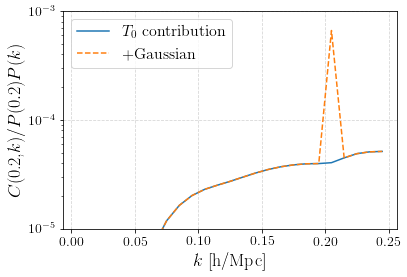

In [15]:
plt.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)
plt.semilogy(k,plotTrisp)
plt.semilogy(k,total,ls='dashed')
plt.legend(['$T_0$ contribution','+Gaussian'], loc=2)
plt.xlabel(r"$k$  [h/Mpc]"); plt.ylabel(r"$C$("+str(round(k[it],2))+",$k)/P("+str(round(k[it],2))+")P(k)$")
plt.ylim(1e-5,1e-3)

# Note the T0 term goes negative for low-k due to significantly negative values of b2 and b3

In [16]:
# For Generating the full covariance matrix
covMat= np.zeros((len(k),len(k)));
covMat=trisp(k,k) # Calculating the tree-level trispectrum

# Adding the Gaussian part
for i in range(len(k)):
    covMat[i,i]+=CovGaussian[i]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

(3e-06, 0.002)

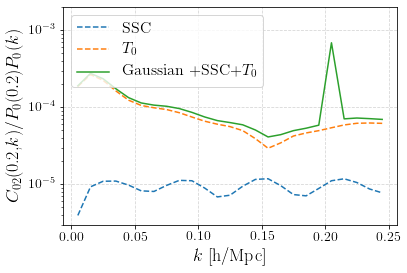

In [51]:
# Optional code:
# In case one wants to include super-sample covariance contribution, 
# run the redshift space section with be=0, l1=0, l2=0

plotSSC=covaSSC(0,0)[it]/(Pfit(k[it])*Pfit(k))
total=plotSSC+plotTrisp
total[it]+=CovGaussian[it]/(Pfit(k[it])**2) # Adding the Gaussian part

plt.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)
plt.semilogy(k,plotSSC, '--')
plt.semilogy(k,plotTrisp, '--')
plt.semilogy(k,total)
plt.legend(['SSC','$T_0$','Gaussian +SSC+$T_0$'], loc=2)
plt.xlabel(r"$k$  [h/Mpc]"); plt.ylabel(r"$C_{02}$("+str(round(k[it],2))+",$k)/P_0("+str(round(k[it],2))+")P_0(k)$")
plt.ylim(3e-6,2e-3)

# Redshift space

In [39]:
# Kaiser terms

rsd=np.zeros(5)
rsd[0]=1 + (2*be)/3 + be**2/5
rsd[2]=(4*be)/3 + (4*be**2)/7
rsd[4]=(8*be**2)/35

In [40]:
#INPUT

#Best-fit theory power multipoles fitted to survey data (currently implemented as Kaiser*Plin)

PfitM= lambda k: Plin(k)*rsd[0]
PfitQ= lambda k: Plin(k)*rsd[2]
PfitH= lambda k: Plin(k)*rsd[4]

PfitM_SN= lambda k: PfitM(k) + inbar #Note shot noise is included here

In [19]:
# Calculating the Gaussian part
def CovGaussian(l1,l2):
    if(l1==l2==0): exp = PfitM_SN(k)**2 + 1/5.*PfitQ(k)**2 + 1/9.*PfitH(k)**2;
    elif(l1==0 and l2==2): exp = 2*PfitM_SN(k)*PfitQ(k) + 2/7.*PfitQ(k)**2 + 4/7.*PfitQ(k)*PfitH(k)+ 100/693.*PfitH(k)**2;
    elif(l1==l2==2): exp = 5*PfitM_SN(k)**2+20/7*PfitM_SN(k)*PfitQ(k)+20/7*PfitM_SN(k)*PfitH(k)\
                        + 15/7.*PfitQ(k)**2 + 120/77.*PfitQ(k)*PfitH(k)+ 8945/9009.*PfitH(k)**2;
    elif(l1==0 and l2==4): exp = 2*PfitM_SN(k)*PfitH(k)+18/35*PfitQ(k)**2+40/77*PfitQ(k)*PfitH(k)+ 162/1001.*PfitH(k)**2;
    elif(l1==2 and l2==4): exp = 36/7*PfitM_SN(k)*PfitQ(k)+200/77*PfitM_SN(k)*PfitH(k)\
                        + 108/77.*PfitQ(k)**2 + 3578/1001*PfitQ(k)*PfitH(k)+ 900/1001*PfitH(k)**2;
    elif(l1==l2==4): exp = 9*PfitM_SN(k)**2+360/77*PfitM_SN(k)*PfitQ(k)+2916/1001*PfitM_SN(k)*PfitH(k)\
                        + 16101/5005*PfitQ(k)**2 + 3240/1001*PfitQ(k)*PfitH(k)+ 42849/17017*PfitH(k)**2;
    
    exp*=2/Nmodes
    return(exp)

In [338]:
# Extra code (no need to run): Provided in case one wants to derive the coefficients in the above cell

# from sympy import Rational, integrate
# mu=symbols('mu')

# def lp(l):
#     if (l==0): exp=1
#     if (l==2): exp=Rational(3/2)*mu**2 - Rational(1/2)
#     if (l==4): exp=Rational(35/8)*mu**4 - Rational(30/8)*mu**2 + Rational(3/8)
#     return(exp)

# Rational(81/2)*integrate(lp(4)*lp(4)*lp(4)*lp(4), (mu,-1,1))

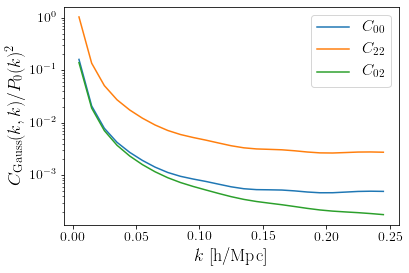

In [20]:
# Plots for Gaussian parts
plt.semilogy(k,CovGaussian(0,0)/(PfitM(k)**2))
plt.semilogy(k,CovGaussian(2,2)/(PfitM(k)**2))
plt.semilogy(k,CovGaussian(0,2)/(PfitM(k)**2))
plt.xlabel(r"$k$  [h/Mpc]"); plt.ylabel(r"$C_\mathrm{Gauss}(k,k)/P_0(k)^2$")
plt.legend(['$C_{00}$','$C_{22}$','$C_{02}$'], loc=1)

## Regular trispectrum part

In [428]:
# Now calculating terms for the non-Gaussisan part, let us first focus on the trispectrum terms

In [21]:
def trispIntegrand(u12,k1,k2):
    return((8*(Plin(k1)**2*T0.e44o44_1(u12,k1,k2) + Plin(k2)**2*T0.e44o44_1(u12,k2,k1))\
        +16*Plin(k1)*Plin(k2)*T0.e44o44_2(u12,k1,k2)\
        +8*inbar*(Plin(k1)*T0.e34o44_2(u12,k1,k2)+Plin(k2)*T0.e34o44_2(u12,k2,k1))\
        +2*inbar**2*T0.e24o44(u12,k1,k2))*\
        Plin(np.sqrt(k1**2+k2**2+2*k1*k2*u12)))

In [22]:
# Returns the tree-level trispectrum as a function of multipoles and k1, k2

def trisp(l1,l2,k1,k2):
    T0.l1=l1; T0.l2=l2
    expr = Plin(k1)**2*Plin(k2)*T0.ez3(k1,k2) + Plin(k2)**2*Plin(k1)*T0.ez3(k2,k1)\
        +8*inbar*Plin(k1)*Plin(k2)*T0.e34o44_1(k1,k2)
    
    temp = (quad(trispIntegrand, -1, 1,args=(k1,k2))[0]/2. + expr)/vol
    return(temp)

trisp = np.vectorize(trisp)

In [23]:
# For making plots of a row of the covariance
l1=0; l2=2 # multipoles
it=15; #row index
plotTrisp=trisp(l1,l2,k[it],k)/(PfitM(k[it])*PfitM(k))
total=plotTrisp.copy()
total[it]+=CovGaussian(l1,l2)[it]/(PfitM(k[it])**2) # Adding the Gaussian part

Text(0, 0.5, '$C_{02}$(0.15,$k)/P_0(0.15)P_0(k)$')

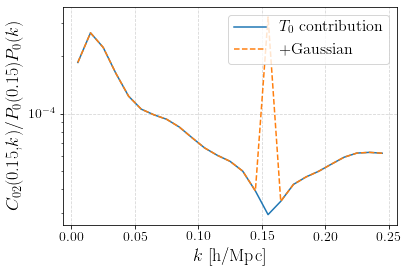

In [24]:
plt.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)
plt.semilogy(k,plotTrisp)
plt.semilogy(k,total,ls='dashed')
plt.legend(['$T_0$ contribution','+Gaussian'], loc=1)
plt.xlabel(r"$k$  [h/Mpc]"); plt.ylabel(r"$C_{02}$("+str(round(k[it],2))+",$k)/P_0("+str(round(k[it],2))+")P_0(k)$")

## Adding super sample covariance (SSC)

In [14]:
# Note that there are no super sample modes if the box is strictly periodic. 
# However, in case one wants to check if including super-sample modes doesn't changes the results of the analysis,
# we include this module for the SSC contribution due to modes outside the box 
# (which is the case when the box is cut from a larger simulated volume)

In [41]:
# Derivatives of the linear power spectrum
dlnPk=derivative(Plin,k,dx=1e-4)*k/Plin(k)

In [105]:
# Calculating RMS of fluctuations of super-survey modes 

# Caution: takes a lot of time to run. For a 1 Gpc side box, output should be something close to few*1e-5

# def pwk(kx,ky,kz):
#     return(Plin(sqrt(kx**2+ky**2+kz**2))*(sin(kx*Lbox/2.)*sin(ky*Lbox/2.)*sin(kz*Lbox/2.)*8/kx/ky/kz)**2 )

#Specify kcut to cut the integral (use kmin!=0 if Plin starts from k=kmin)
# kcut=0.15; kmin=0
# 1/pi**3/vol**2*tplquad(pwk, kmin, kcut, lambda x: kmin, lambda x: kcut, lambda x, y: kmin, lambda x, y: kcut,
#                    epsabs=1e-3, epsrel=1e-2)[0]

5.392154987341747e-05

In [42]:
#INPUT

# Currently using here the value from the above cell for 1 Gpc/h box. 
# Uncomment and run the above cell for a different Lbox or Plin.
# For a periodic box sigma22Sq= sigma10Sq= sigma22x10. Definition in Eq. (33) in WadSco19

sigma22Sq = np.zeros((3,3))
sigma22Sq[0, 0] = 5.4e-5; sigma22Sq[1, 1]=sigma22Sq[0, 0]/5; sigma22Sq[2, 2]=sigma22Sq[0, 0]/9;

In [43]:
# Using the Z12 kernel which is defined in Eq. (A9)

def Z12Kernel(l,mu,dlnpk):
    if(l==0):
        exp=(7*b1**2*be*(70 + 42*be + (-35*(-3 + dlnpk) + 3*be*(28 + 13*be - 14*dlnpk - 5*be*dlnpk))*mu**2) + 
            b1*(35*(47 - 7*dlnpk) + be*(798 + 153*be - 98*dlnpk - 21*be*dlnpk + 
            4*(84 + be*(48 - 21*dlnpk) - 49*dlnpk)*mu**2)) + 
            98*(5*b2*(3 + be) + 4*g2*(-5 + be*(-2 + mu**2))))/(735.*b1**2)
    elif(l==2):
        exp=(14*b1**2*be*(14 + 12*be + (2*be*(12 + 7*be) - (1 + be)*(7 + 5*be)*dlnpk)*mu**2) + 
            b1*(4*be*(69 + 19*be) - 7*be*(2 + be)*dlnpk + 
            (24*be*(11 + 6*be) - 7*(21 + be*(22 + 9*be))*dlnpk)*mu**2 + 7*(-8 + 7*dlnpk + 24*mu**2)) + 
            28*(7*b2*be + g2*(-7 - 13*be + (21 + 11*be)*mu**2)))/(147.*b1**2)
    elif(l==4):
        exp=(8*be*(b1*(-132 + 77*dlnpk + be*(23 + 154*b1 + 14*dlnpk)) - 154*g2 + 
            (b1*(396 - 231*dlnpk + be*(272 + 308*b1 + 343*b1*be - 7*(17 + b1*(22 + 15*be))*dlnpk)) + 
            462*g2)*mu**2))/(2695.*b1**2)
    return(exp)

In [44]:
# Legendre polynomials
def lp(l,mu):
    if (l==0): exp=1
    if (l==2): exp=((3*mu**2 - 1)/2.)
    if (l==4): exp=((35*mu**4 - 30*mu**2 + 3)/8.)
    return(exp)

In [45]:
# Calculating multipoles of the Z12 kernel
def Z12Multipoles(i,l,dlnpk):
    return(quad(lambda mu: lp(i,mu)*Z12Kernel(l,mu,dlnpk), -1, 1)[0])

Z12Multipoles = np.vectorize(Z12Multipoles)

# Terms used in the LA calculation
covaLAterm=np.zeros((3,len(k)))
for l in range(3):
    for i in range(3):
        for j in range(3):
            covaLAterm[l]+=1/4.*sigma22Sq[i,j]*Z12Multipoles(2*i,2*l,dlnPk)\
                                    *quad(lambda mu: lp(2*j,mu)*(1 + be*mu**2), -1, 1)[0]
            
sigma10Sq=1/vol
for i in range(3):
    for j in range(3):
        sigma10Sq+=1/4.*sigma22Sq[i,j]*quad(lambda mu: lp(2*i,mu)*(1 + be*mu**2), -1, 1)[0]\
            *quad(lambda mu: lp(2*j,mu)*(1 + be*mu**2), -1, 1)[0]

In [46]:
# Returns the SSC covariance matrix contrbution

# BC= beat-coupling, LA= local average effect, SSC= super sample covariance
def covaSSC(l1,l2):
    covaBC=np.zeros((len(k),len(k)))
    for i in range(3):
        for j in range(3):
            covaBC+=1/4.*sigma22Sq[i,j]*np.outer(Plin(k)*Z12Multipoles(2*i,l1,dlnPk),Plin(k)
                                                 *Z12Multipoles(2*j,l2,dlnPk))

    covaLA=-rsd[l2]*np.outer(Plin(k)*(covaLAterm[int(l1/2)]+1/vol*rsd[l1]*Plin(k)*b2/b1**2+2/vol*rsd[l1]),Plin(k))\
            -rsd[l1]*np.outer(Plin(k),Plin(k)*(covaLAterm[int(l2/2)]+1/vol*rsd[l2]*Plin(k)*b2/b1**2+2/vol*rsd[l2]))\
            +sigma10Sq*rsd[l1]*rsd[l2]*np.outer(Plin(k),Plin(k))
    
# As mentioned in Section 7 in WadSco19, if one uses the deP12 estimator for overdensity of the box
# (i.e. dividing by the mean density of the box for calculating overdensity), 
# then one should use the following commented term instead of the above one;
# the above one is for an FKP-like estimator
    
#     covaLA=-2*rsd[l2]*np.outer(Plin(k)*(covaLAterm[int(l1/2)]+1/vol*rsd[l1]*Plin(k)*b2/b1**2+2/vol*rsd[l1]),Plin(k))\
#             -2*rsd[l1]*np.outer(Plin(k),Plin(k)*(covaLAterm[int(l2/2)]+1/vol*rsd[l2]*Plin(k)*b2/b1**2+2/vol*rsd[l2]))\
#             +4*sigma10Sq*rsd[l1]*rsd[l2]*np.outer(Plin(k),Plin(k))

    return(covaBC+covaLA)

In [31]:
# For making plots of a row of the covariance
l1=0; l2=2 # multipoles
it=15; #row index
plotSSC=covaSSC(l1,l2)[it]/(PfitM(k[it])*PfitM(k))
total=plotSSC+plotTrisp
total[it]+=CovGaussian(l1,l2)[it]/(PfitM(k[it])**2) # Adding the Gaussian part

Text(0, 0.5, '$C_{02}$(0.15,$k)/P_0(0.15)P_0(k)$')

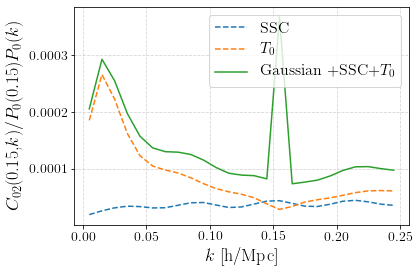

In [32]:
plt.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)
plt.plot(k,plotSSC, '--')
plt.plot(k,plotTrisp, '--')
plt.plot(k,total)
plt.legend(['SSC','$T_0$','Gaussian +SSC+$T_0$'], loc=1)
plt.xlabel(r"$k$  [h/Mpc]"); plt.ylabel(r"$C_{02}$("+str(round(k[it],2))+",$k)/P_0("+str(round(k[it],2))+")P_0(k)$")

## Combining the multipoles for a joint covariance

In [33]:
# Constructing multipole covariance
covaGmult=np.zeros((2*kbins,2*kbins))
for i in range(kbins):
    covaGmult[i,i]=CovGaussian(0,0)[i]
    covaGmult[i,kbins+i]=CovGaussian(0,2)[i]
    covaGmult[kbins+i,i]=CovGaussian(0,2)[i]
    covaGmult[kbins+i,kbins+i]=CovGaussian(2,2)[i]

In [34]:
# Constructing multipole covariance
covaT0mult=np.zeros((2*kbins,2*kbins))
covaT0mult[:kbins,:kbins]=trisp(0,0,k,k)
covaT0mult[kbins:,kbins:]=trisp(2,2,k,k) 
covaT0mult[:kbins,kbins:]=trisp(0,2,k,k); covaT0mult[kbins:,:kbins]=np.transpose(covaT0mult[:kbins,kbins:])

covaSSCmult=np.zeros((2*kbins,2*kbins))
covaSSCmult[:kbins,:kbins]=covaSSC(0,0)
covaSSCmult[kbins:,kbins:]=covaSSC(2,2)
covaSSCmult[:kbins,kbins:]=covaSSC(0,2); covaSSCmult[kbins:,:kbins]=np.transpose(covaSSCmult[:kbins,kbins:])

In [35]:
covaMult=covaGmult+covaT0mult+covaSSCmult

In [36]:
# For making plots comparing the diagonal elements

[plot,plot2,plot3,plot4,plot5,plot6]=np.zeros((6,2*kbins))
norm=np.append(PfitM(k),PfitQ(k))
for i in range(2*kbins):
    plot[i]=covaGmult[i,i]/norm[i]
    plot2[i]=covaT0mult[i,i]/norm[i]
    plot3[i]=covaSSCmult[i,i]/norm[i]
    plot4[i]=covaMult[i,i]/norm[i]

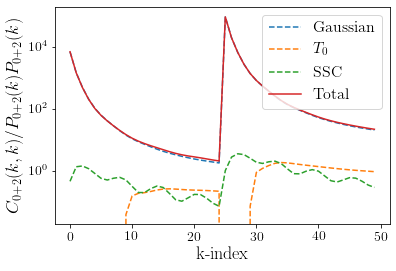

In [37]:
plt.semilogy(plot,'--');
plt.semilogy(plot2, ls='--');
plt.semilogy(plot3, ls='--');
plt.semilogy(plot4);
plt.xlabel(r'k-index'); plt.ylabel(r'$C_{0+2}(k,k)/P_{0+2} (k) P_{0+2}(k)$')
plt.legend(["Gaussian","$T_0$","SSC","Total"], loc=1)